### SageMaker Stable diffusion Quick Kit - Inference 部署
   [SageMaker Stable Diffusion Quick Kit](https://github.com/aws-samples/sagemaker-stablediffusion-quick-kit) 提供了一组开箱即用的代码、配置文件，它可以帮助客户在亚马逊云上使用Amazon SageMaker , Lambda, Cloudfront快速构建Stable diffusion AI绘图服务.
   
   ![架构](https://raw.githubusercontent.com/aws-samples/sagemaker-stablediffusion-quick-kit/main/images/architecture.png)


#### 前提条件
1. 亚马逊云账号
2. 建议使用ml.g4dn.xlarge/ml.g5.xlarge

### Notebook部署步骤
1. 升级boto3, sagemaker python sdk
2. 部署AIGC推理服务
    * 配置模型参数
    * 配置异步推理
    * 部署SageMaker Endpoint 
3. 测试模型
4. 配置推理服务弹性伸缩策略(可选)
5. 清除资源


### 1. 升级boto3, sagemaker python sdk

In [1]:
!pip install --upgrade boto3 sagemaker

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import time
import boto3
import sagemaker
account_id = boto3.client('sts').get_caller_identity().get('Account')
region_name = boto3.session.Session().region_name

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

print(role)

arn:aws:iam::805911210251:role/TeamRole


### 2. 部署AIGC推理服务

#### 2.1 配置模型参数
   * model_name: 支持 Huggingface diffusers models 结构，
       * 可以直接使用Huggingface的名字:Linaqruf/anything-v3.0
       * s3://sagemaker-us-east-1-123456789011/dreambooth/trained_models/model.tar.gz
       * 目前不支持.ckpt(single check point format),请使用转换脚本转换为diffusers格式
   * model_args:  diffuser StableDiffusionPipeline init arguments
   * framework_version: pytroch版本
   * py_version: python版本
   * model_environment: 推理环境变量

In [3]:

framework_version = '1.10'
py_version = 'py38'

model_environment = {
    'SAGEMAKER_MODEL_SERVER_TIMEOUT':'600', 
    'SAGEMAKER_MODEL_SERVER_WORKERS': '1', 
    'model_name':'andite/anything-v4.0',
    's3_bucket':bucket
}

#### 2.2 创建dummy model_data 文件(真正的模型使用infernece.py进行加载), 为SageMaker Endpoint 创建 PyTorchModel 

In [4]:
!touch dummy
!tar czvf model.tar.gz dummy sagemaker-logo-small.png
assets_dir = 's3://{0}/{1}/assets/'.format(bucket, 'stablediffusion')
model_data = 's3://{0}/{1}/assets/model.tar.gz'.format(bucket, 'stablediffusion')
!aws s3 cp model.tar.gz $assets_dir
!rm -f dummy model.tar.gz

dummy
sagemaker-logo-small.png
upload: ./model.tar.gz to s3://sagemaker-us-east-1-805911210251/stablediffusion/assets/model.tar.gz


In [5]:
from sagemaker.pytorch.model import PyTorchModel

model = PyTorchModel(
    name = None,
    model_data = model_data,
    entry_point = 'inference.py',
    source_dir = "./code/",
    role = role,
    framework_version = framework_version, 
    py_version = py_version,
    env = model_environment
)

#### 2.3 配置异步推理、设置推理使用的实例类型


In [6]:
from sagemaker.async_inference import AsyncInferenceConfig
import uuid

endpoint_name = f'AIGC-Quick-Kit-{str(uuid.uuid4())}'
instance_type = 'ml.g4dn.xlarge'
instance_count = 1
async_config = AsyncInferenceConfig(output_path='s3://{0}/{1}/asyncinvoke/out/'.format(bucket, 'stablediffusion'))

print(f'endpoint_name: {endpoint_name}')

endpoint_name: AIGC-Quick-Kit-c37c3e6d-44db-42fc-a2d1-8307468b23f9


#### 2.4 部署SageMaker Endpoint

In [7]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer


async_predictor = model.deploy(
    endpoint_name = endpoint_name,
    instance_type = instance_type, 
    initial_instance_count = instance_count,
    async_inference_config = async_config,
    serializer = JSONSerializer(),
    deserializer = JSONDeserializer()
)

---------!


#### 2.5 编写异步推理调用辅助方法(适用于Notebook)
 * get_bucket_and_key, read s3 object
 * draw_image, download image from s3 and draw it in notebook
 * async_predict_fn 


In [8]:
import json
import io
from PIL import Image
import traceback
import time
from sagemaker.async_inference.waiter_config import WaiterConfig


s3_resource = boto3.resource('s3')

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key

def draw_image(response):
    try:
        bucket, key = get_bucket_and_key(response.output_path)
        obj = s3_resource.Object(bucket, key)
        body = obj.get()['Body'].read().decode('utf-8') 
        predictions = json.loads(body)['result']
        print(predictions)
        for prediction in predictions:
            bucket, key = get_bucket_and_key(prediction)
            obj = s3_resource.Object(bucket, key)
            bytes = obj.get()['Body'].read()
            image = Image.open(io.BytesIO(bytes))
            image.show()
    except Exception as e:
        traceback.print_exc()
        print(e)


def async_predict_fn(predictor,inputs):
    response = predictor.predict_async(inputs)
    
    print(f"Response object: {response}")
    print(f"Response output path: {response.output_path}")
    print("Start Polling to get response:")
    
    start = time.time()
    config = WaiterConfig(
        max_attempts=100, #  number of attempts
        delay=10 #  time in seconds to wait between attempts
    )

    response.get_result(config)
    draw_image(response)

    print(f"Time taken: {time.time() - start}s")

### 3. 测试
 3.1 txt2img 文本到图片推理

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7f1852b725f0>
Response output path: s3://sagemaker-us-east-1-805911210251/stablediffusion/asyncinvoke/out/9cec00a4-8b58-4a4a-8542-86b21ca24a6e.out
Start Polling to get response:
['s3://sagemaker-us-east-1-805911210251/stablediffusion/asyncinvoke/images/e28084ab-dfb5-4d10-a3c5-d47bd7a5dc43.jpg', 's3://sagemaker-us-east-1-805911210251/stablediffusion/asyncinvoke/images/69ea98bf-06ee-48a1-ba67-7c6e5f3aa6e6.jpg']


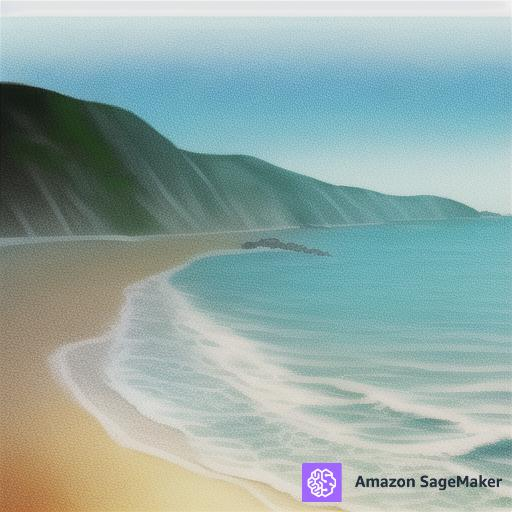

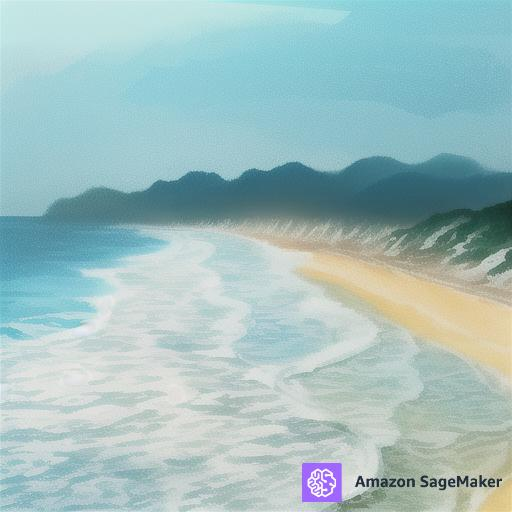

Time taken: 20.576160669326782s
Time taken: 20.786665201187134s


In [10]:
#AIGC Quick Kit txt2img
inputs_txt2img = {
    "prompt": "a picture of beach, which like the beach of Dalian China, and it is the style of ink painting",
    "negative_prompt":"",
    "steps":20,
    "sampler":"euler_a",
    "seed": 52362,
    "height": 512, 
    "width": 512,
    "count":2

}
start=time.time()
async_predict_fn(async_predictor,inputs_txt2img)
print(f"Time taken: {time.time() - start}s")

 3.2 img2img 图片到图片推理
  
 * 原始图片 :![](https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg)

Response object: <sagemaker.async_inference.async_inference_response.AsyncInferenceResponse object at 0x7f18d9665d80>
Response output path: s3://sagemaker-us-east-1-805911210251/stablediffusion/asyncinvoke/out/612d7e7e-3cc1-407e-bd6a-386010de7260.out
Start Polling to get response:
['s3://sagemaker-us-east-1-805911210251/stablediffusion/asyncinvoke/images/ca49d5d1-c326-4029-ad09-461399cf6eb9.jpg', 's3://sagemaker-us-east-1-805911210251/stablediffusion/asyncinvoke/images/185cf8f5-34eb-458e-bf3b-ad1552f854ea.jpg']


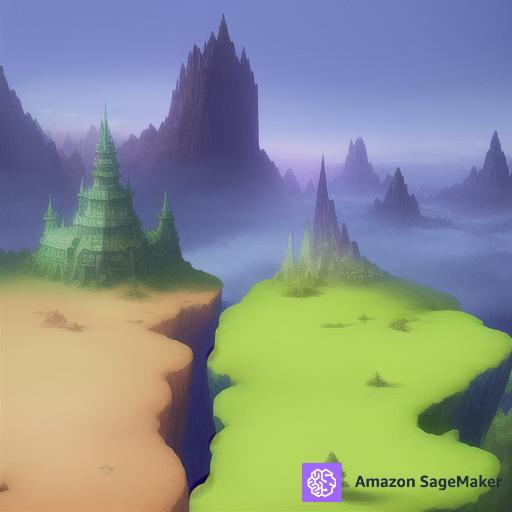

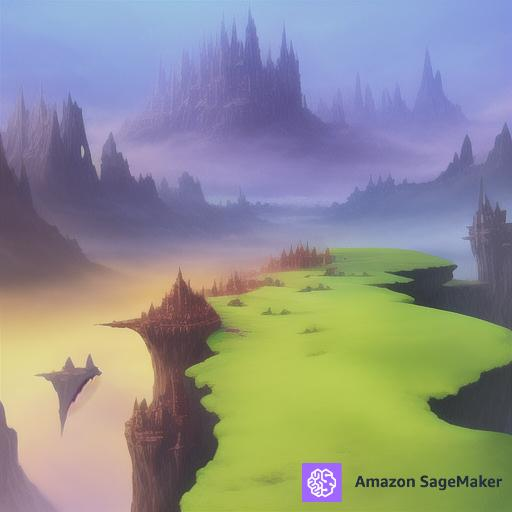

Time taken: 10.477249145507812s


In [12]:
#AIGC Quick Kit img2img

inputs_img2img = {
    "prompt": "A fantasy landscape, trending on artstation in ink style",
    "negative_prompt":"",
    "steps":20,
    "sampler":"euler_a",
    "seed":43768,
    "height": 512, 
    "width": 512,
    "count":2,
    "input_image":"https://raw.githubusercontent.com/CompVis/stable-diffusion/main/assets/stable-samples/img2img/sketch-mountains-input.jpg"

}

async_predict_fn(async_predictor,inputs_img2img)

### 4. 配置推理服务弹性伸缩策略(可选)

In [ ]:
# application-autoscaling client
asg_client = boto3.client("application-autoscaling")

# This is the format in which application autoscaling references the endpoint
resource_id = f"endpoint/{async_predictor.endpoint_name}/variant/AllTraffic"

# Configure Autoscaling on asynchronous endpoint down to zero instances
response = asg_client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=2,
)

response = asg_client.put_scaling_policy(
    PolicyName=f'Request-ScalingPolicy-{async_predictor.endpoint_name}',
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    PolicyType="TargetTrackingScaling",
    TargetTrackingScalingPolicyConfiguration={
        "TargetValue": 2.0,
        "CustomizedMetricSpecification": {
            "MetricName": "ApproximateBacklogSizePerInstance",
            "Namespace": "AWS/SageMaker",
            "Dimensions": [{"Name": "EndpointName", "Value": async_predictor.endpoint_name}],
            "Statistic": "Average",
        },
        "ScaleInCooldown": 600, # duration until scale in begins (down to zero)
        "ScaleOutCooldown": 300 # duration between scale out attempts
    },
)

#### 通过并发推理，测试伸缩策略

In [ ]:
import time
import random

start = time.time()

outputs=[]

def build_prompts_with_random_seed():
    return {
        "prompt": "a photo of an astronaut riding a horse on mars",
        "negative_prompt":"",
        "steps":50,
        "sampler":"ddim",
        "seed": random.randint(52362, 99999999),
        "height": 512, 
        "width": 512,
        "count":2

    }

# send 10 requests
for i in range(10):
    prediction = async_predictor.predict_async(build_prompts_with_random_seed())
    outputs.append(prediction)

# iterate over list of output paths and get results
results = []
for output in outputs:
    response = output.get_result(WaiterConfig(max_attempts=600))
    results.append(response)

print(f"Time taken: {time.time() - start}s")
print(results)

#### 绘制推理结果


In [ ]:
for r in results:
    for item in r["result"]:
        bucket, key = get_bucket_and_key(item)
        obj = s3_resource.Object(bucket, key)
        bytes = obj.get()['Body'].read()
        image = Image.open(io.BytesIO(bytes))
        image.show()


In [ ]:
response = asg_client.deregister_scalable_target(
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:variant:DesiredInstanceCount'
)


### 5. 清除资源

In [ ]:
async_predictor.delete_endpoint()